In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

import matplotlib.pyplot as plt


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [2]:
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

In [45]:
# each word is randomly assigned to a topic. 
# This randomness could be uniform initialization if the alpha is large, or skewed initialization when the alpha is small. 
doc_topic_prior__uniform = 1.
doc_topic_prior__skewed = 1 / n_components

```txt
for d in all_documents_D:    
    for w in all_words_W_in_d:        
        for z in all_topics_Z:            
            w_in_z = count(across all documents times w is assigned to z)
            d_in_z = count(in d all words that belong to z)            
            tokens_in_z = count(all assignments in z)            
            p(z| w, d) = w_in_z * d_in_z / tokens_in_z        
            # so w belong to max p(z)        
            # whichever topic the probability was maximum for w       
            w_z = max(p(z| w, d))
```

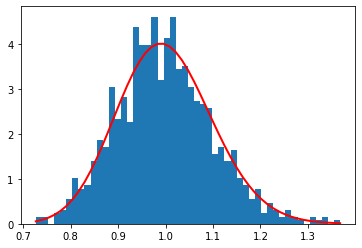

In [77]:
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html
import numpy as np
from scipy.stats import gamma

shape, scale = 100., 1/100.  # mean=4, std=2*sqrt(2)
# s = np.random.gamma(shape, scale, 1000)
s = gamma.rvs(shape, size=1000, scale=scale)

import matplotlib.pyplot as plt
import scipy.special as sps  

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.show()

In [50]:
lda = LatentDirichletAllocation(
    n_components=n_components, 
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0,
    doc_topic_prior=doc_topic_prior__skewed
)
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.1, learning_method='online',
                          learning_offset=50.0, max_iter=5, random_state=0)

In [141]:
from sklearn_guided_lda import GuidedLDA

seeds = [
    ["game", "team", "play", "season"],
    ["religion", "christian", "god", "jesus"]
]
glda = GuidedLDA(
    tf_vectorizer=tf_vectorizer,
    seed_words=seeds,
    seed_confidence=100.,
    doc_topic_prior=doc_topic_prior__uniform,
    n_components=n_components, 
    max_iter=20,
    learning_method='online',
    learning_offset=50.,
    random_state=0
)
glda.fit(tf)

GuidedLDA(doc_topic_prior=1.0, learning_method='online', learning_offset=50.0,
          max_iter=20, random_state=0,
          seed_words=[['game', 'team', 'play', 'season'],
                      ['religion', 'christian', 'god', 'jesus']],
          tf_vectorizer=CountVectorizer(max_df=0.95, max_features=1000,
                                        min_df=2, stop_words='english'))

In [36]:
import seaborn as sns

<AxesSubplot:>

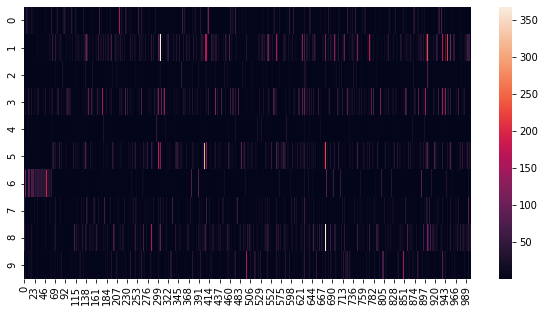

In [128]:
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(lda.components_, ax=ax)

<AxesSubplot:>

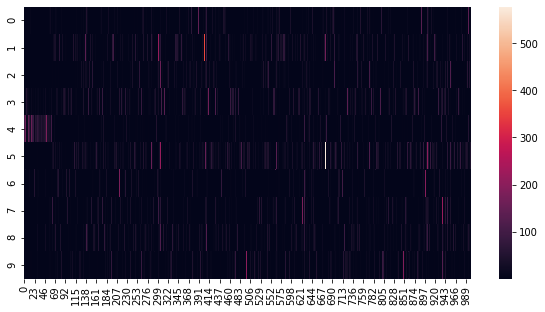

In [136]:
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(glda.components_, ax=ax)

In [123]:
tf_feature_names = tf_vectorizer.get_feature_names()

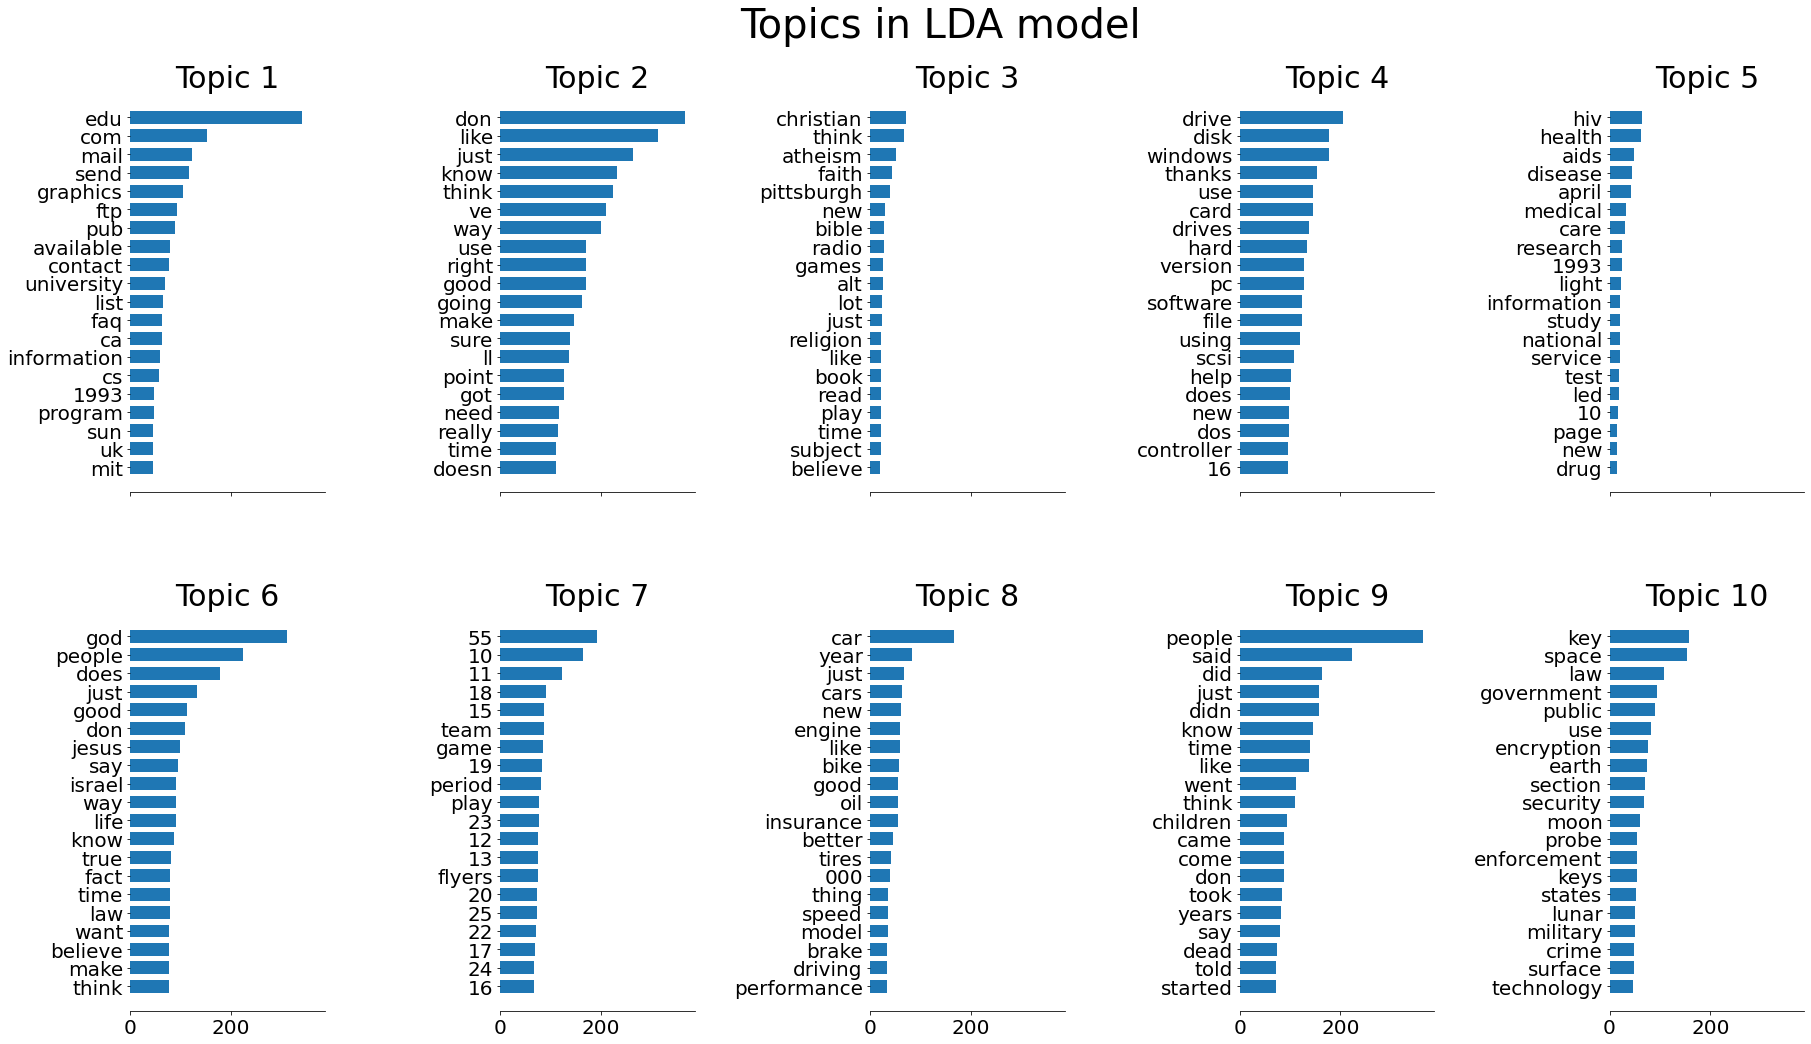

In [137]:
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

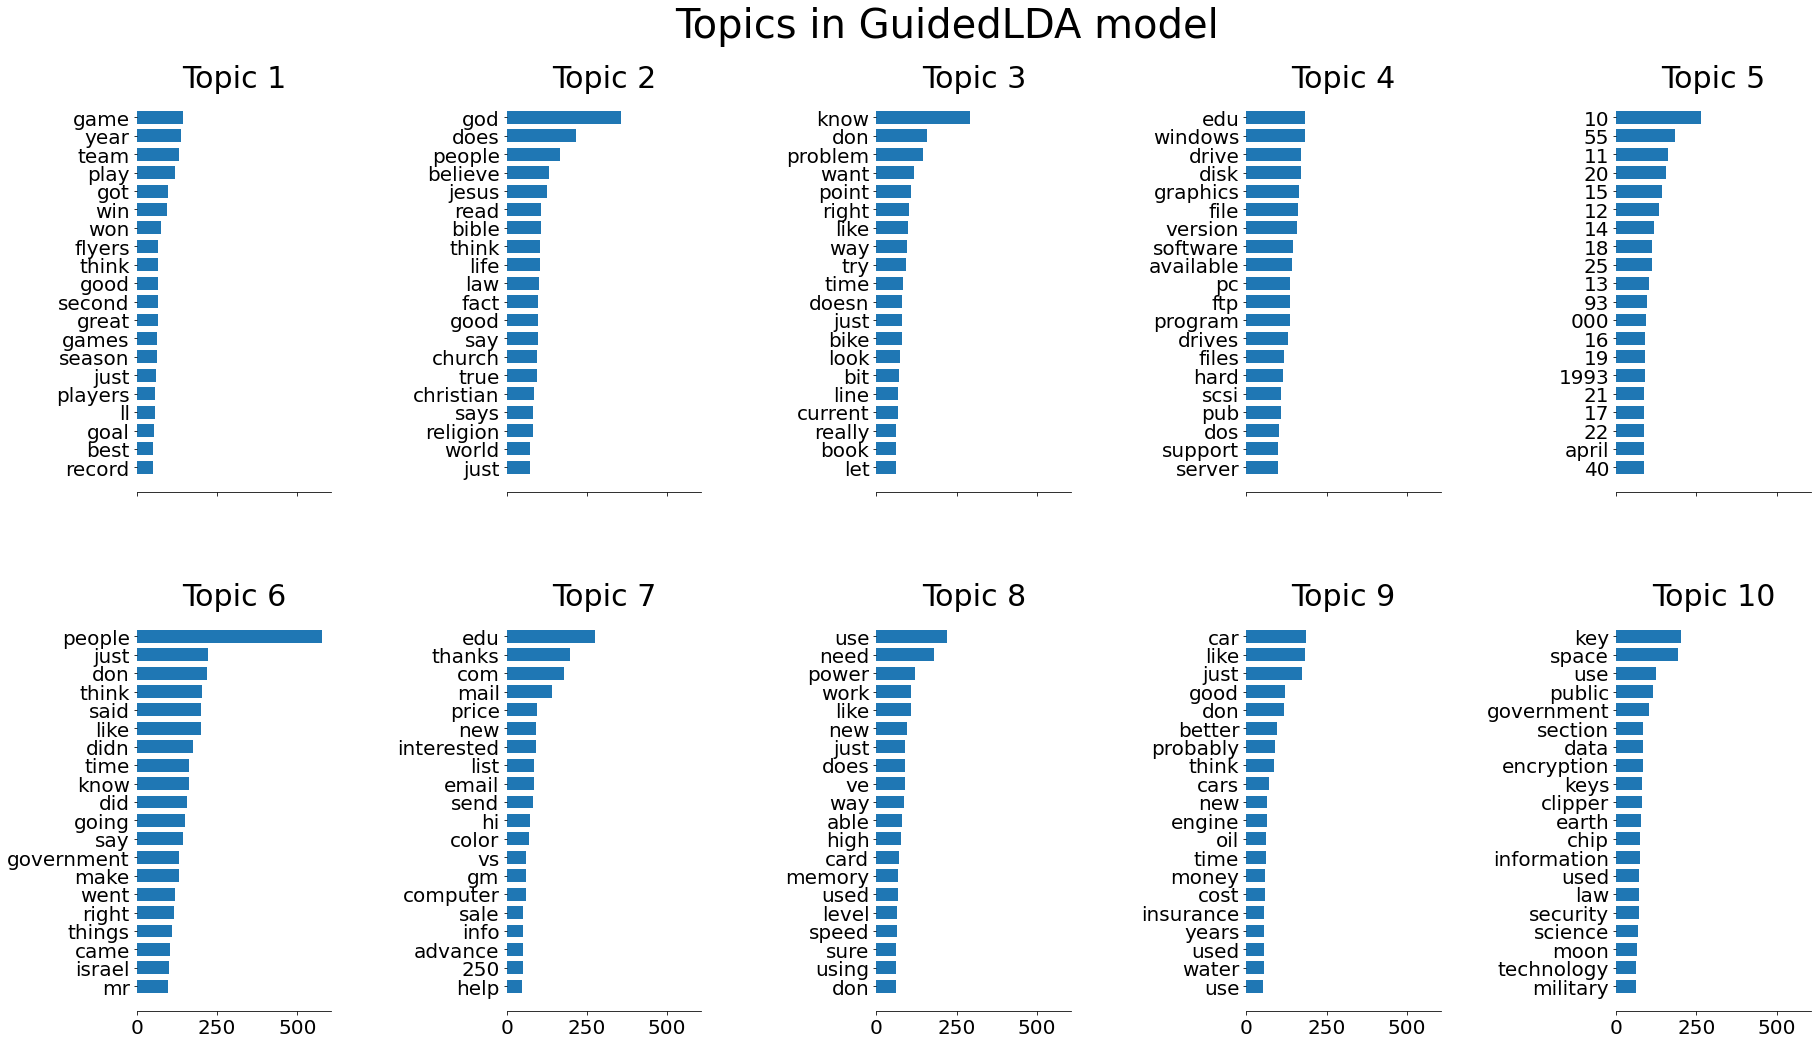

In [138]:
plot_top_words(glda, tf_feature_names, n_top_words, 'Topics in GuidedLDA model')